In [2]:
import pandas as pd
import os, time, random
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers.convolutional import Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import RMSprop
from epftoolbox.evaluation import MAE, MAPE, RMSE, rMAE
from sklearn import metrics

In [3]:
os.chdir('..')
tf.random.set_seed(123)

In [4]:
# Funciones auxiliares
# Romper el dataset
def train_test_vali(serie, train_size, valida_size, ts_size):
    total_data = serie.shape[0]

    train_data = int(total_data * train_size)
    valid_data = int(total_data * valida_size)
    test_data = total_data - train_data - valid_data

    train = serie[0:train_data]
    vali = serie[train_data:train_data + valid_data]
    test = serie[train_data + valid_data:]
    return train, vali, test

#Crear dataset supervisado
def crear_dataset_supervisado(array, input_length, output_length):

    # Inicialización
    X, Y = [], []    # Listados que contendrán los datos de entrada y salida del modelo
    shape = array.shape
    if len(shape)==1: # Si tenemos sólo una serie (univariado)
        fils, cols = array.shape[0], 1
        array = array.reshape(fils,cols)
    else: # Multivariado
        fils, cols = array.shape

    # Generar los arreglos
    for i in range(fils-input_length-output_length):
        X.append(array[i:i+input_length,0:cols])
        Y.append(array[i+input_length:i+input_length+output_length,-1].reshape(output_length,1))
    
    # Convertir listas a arreglos de NumPy
    X = np.array(X)
    Y = np.array(Y)
    
    return X, Y

# Escalamiento de los datos
def escalar_dataset(data_input):
    NFEATS = data_input['x_tr'].shape[2]

    # Generar listado con "scalers"
    scalers = [MinMaxScaler(feature_range=(-1,1)) for i in range(NFEATS)]

    # Arreglos que contendrán los datasets escalados
    x_tr_s = np.zeros(data_input['x_tr'].shape)
    x_vl_s = np.zeros(data_input['x_vl'].shape)
    x_ts_s = np.zeros(data_input['x_ts'].shape)
    y_tr_s = np.zeros(data_input['y_tr'].shape)
    y_vl_s = np.zeros(data_input['y_vl'].shape)
    y_ts_s = np.zeros(data_input['y_ts'].shape)

    # Escalamiento: se usarán los min/max del set de entrenamiento para
    # escalar la totalidad de los datasets

    # Escalamiento Xs
    for i in range(NFEATS):
        x_tr_s[:,:,i] = scalers[i].fit_transform(x_tr[:,:,i])
        x_vl_s[:,:,i] = scalers[i].transform(x_vl[:,:,i])
        x_ts_s[:,:,i] = scalers[i].transform(x_ts[:,:,i])
    
    # Escalamiento Ys
    y_tr_s[:,:,0] = scalers[-1].fit_transform(y_tr[:,:,0])
    y_vl_s[:,:,0] = scalers[-1].transform(y_vl[:,:,0])
    y_ts_s[:,:,0] = scalers[-1].transform(y_ts[:,:,0])

    # Conformar ` de salida
    data_scaled = {
        'x_tr_s': x_tr_s, 'y_tr_s': y_tr_s,
        'x_vl_s': x_vl_s, 'y_vl_s': y_vl_s,
        'x_ts_s': x_ts_s, 'y_ts_s': y_ts_s,
    }

    return data_scaled, scalers[0]

# Auxiliares del modelo
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

def predecir(x, model, scaler, y_real, OUTPUT_LENGTH):
    # Calcular predicción escalada en el rango de -1 a 1
    y_pred_s = model.predict(x,verbose=0)

    # Llevar la predicción a la escala original
    y_pred = scaler.inverse_transform(y_pred_s)
    y_real = scaler.inverse_transform(y_real.reshape(-1, OUTPUT_LENGTH))

    return y_pred.flatten(), y_real.flatten()

# Función para medir el tiempo de ejecución
def elapsed_time(start_time):
    return time.time() - start_time


Epoch 1/50
543/543 [==============================] - 6s 7ms/step - loss: 0.8624 - val_loss: 0.7324
Epoch 2/50
543/543 [==============================] - 3s 6ms/step - loss: 0.6646 - val_loss: 0.5318
Epoch 3/50
543/543 [==============================] - 3s 6ms/step - loss: 0.4470 - val_loss: 0.3193
Epoch 4/50
543/543 [==============================] - 4s 7ms/step - loss: 0.2349 - val_loss: 0.1304
Epoch 5/50
543/543 [==============================] - 3s 6ms/step - loss: 0.0672 - val_loss: 0.0263
Epoch 6/50
543/543 [==============================] - 3s 6ms/step - loss: 0.0301 - val_loss: 0.0259
Epoch 7/50
543/543 [==============================] - 3s 6ms/step - loss: 0.0293 - val_loss: 0.0254
Epoch 8/50
543/543 [==============================] - 3s 6ms/step - loss: 0.0285 - val_loss: 0.0251
Epoch 9/50
543/543 [==============================] - 4s 6ms/step - loss: 0.0280 - val_loss: 0.0248
Epoch 10/50
543/543 [==============================] - 4s 7ms/step - loss: 0.0275 - val_loss: 0.0247

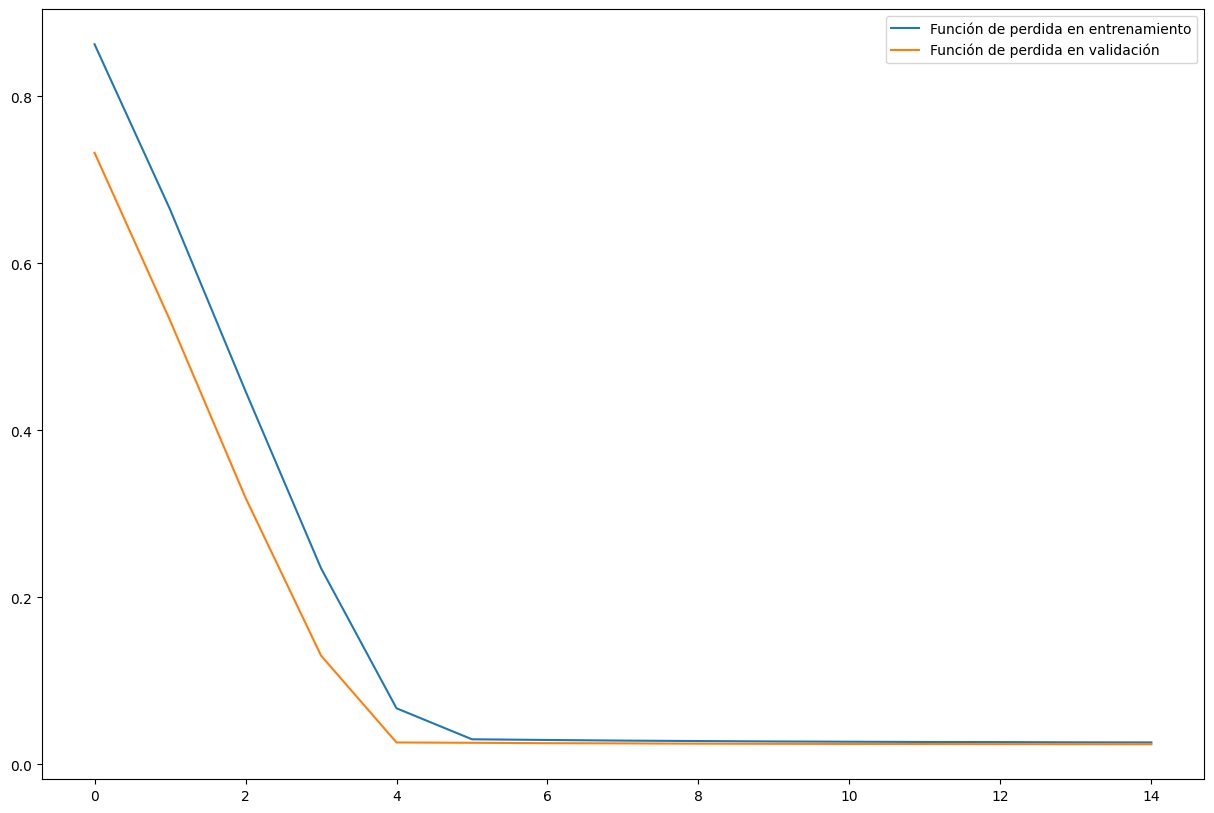

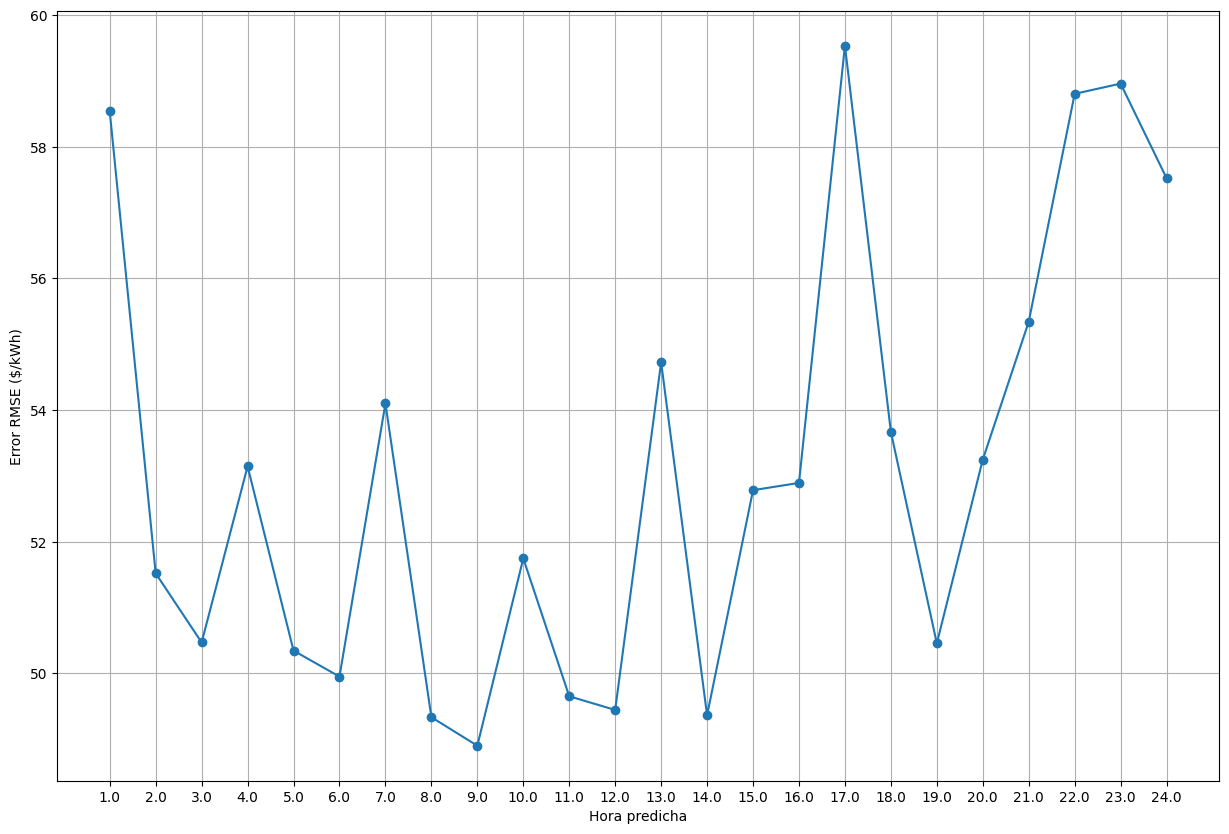

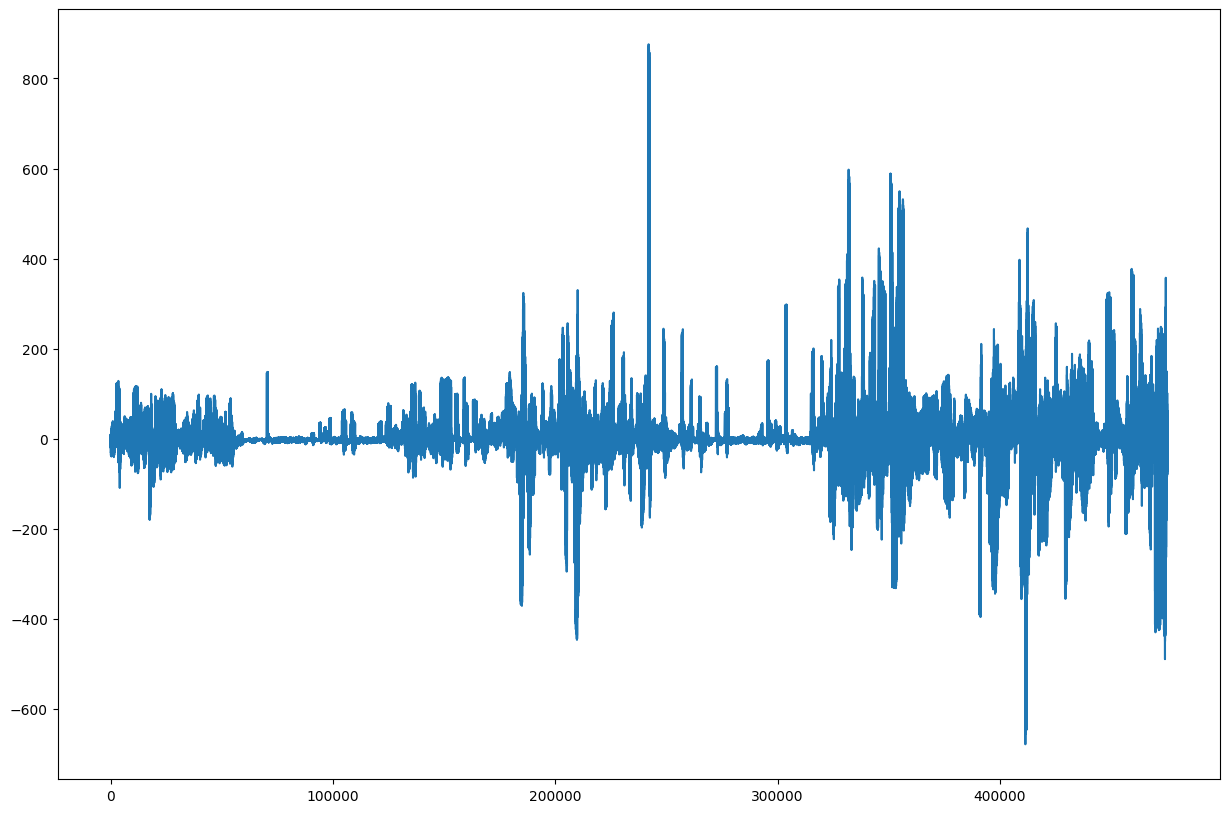

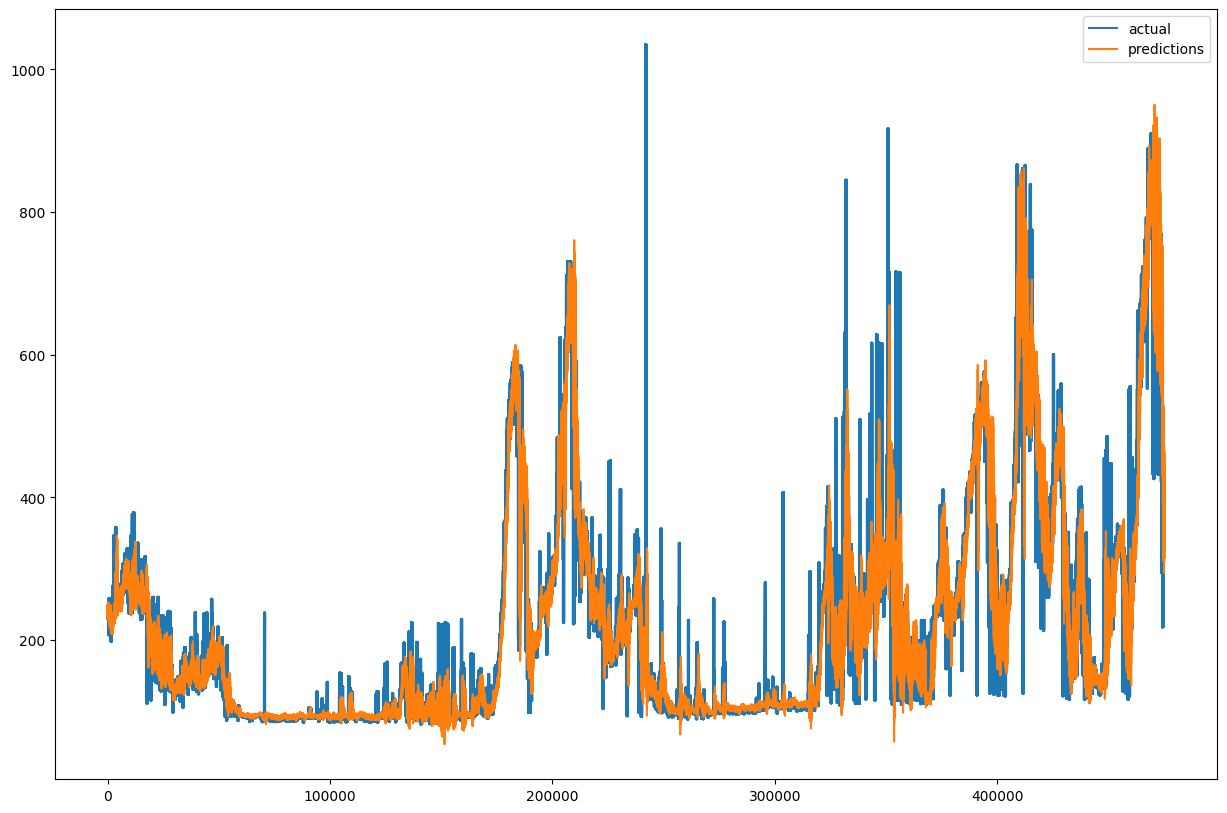

Epoch 1/50
621/621 [==============================] - 6s 6ms/step - loss: 0.9447 - val_loss: 0.7853
Epoch 2/50
621/621 [==============================] - 4s 6ms/step - loss: 0.7749 - val_loss: 0.6286
Epoch 3/50
621/621 [==============================] - 4s 6ms/step - loss: 0.5990 - val_loss: 0.4616
Epoch 4/50
621/621 [==============================] - 4s 6ms/step - loss: 0.4144 - val_loss: 0.2865
Epoch 5/50
621/621 [==============================] - 4s 6ms/step - loss: 0.2168 - val_loss: 0.1063
Epoch 6/50
621/621 [==============================] - 4s 6ms/step - loss: 0.0538 - val_loss: 0.0346
Epoch 7/50
621/621 [==============================] - 4s 6ms/step - loss: 0.0290 - val_loss: 0.0335
Epoch 8/50
621/621 [==============================] - 4s 6ms/step - loss: 0.0281 - val_loss: 0.0332
Epoch 9/50
621/621 [==============================] - 4s 6ms/step - loss: 0.0275 - val_loss: 0.0326
Epoch 10/50
621/621 [==============================] - 4s 6ms/step - loss: 0.0268 - val_loss: 0.0321

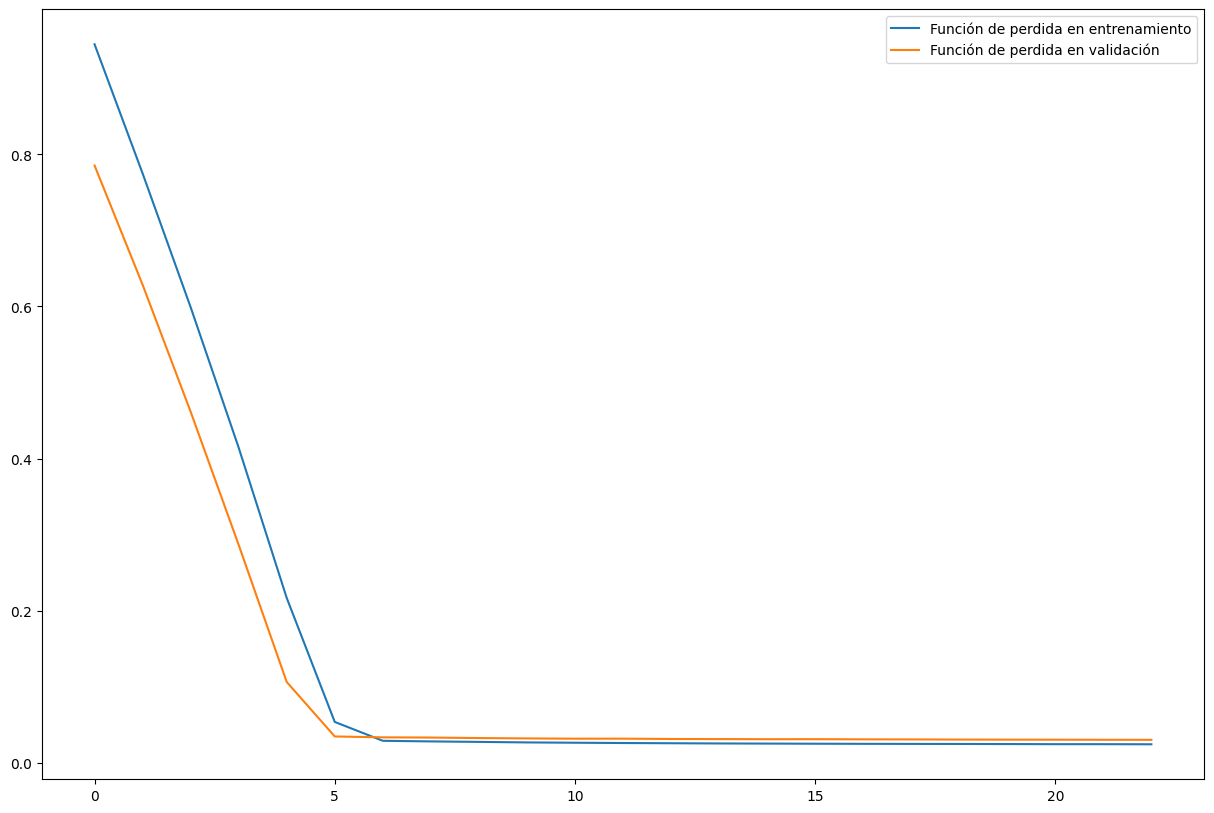

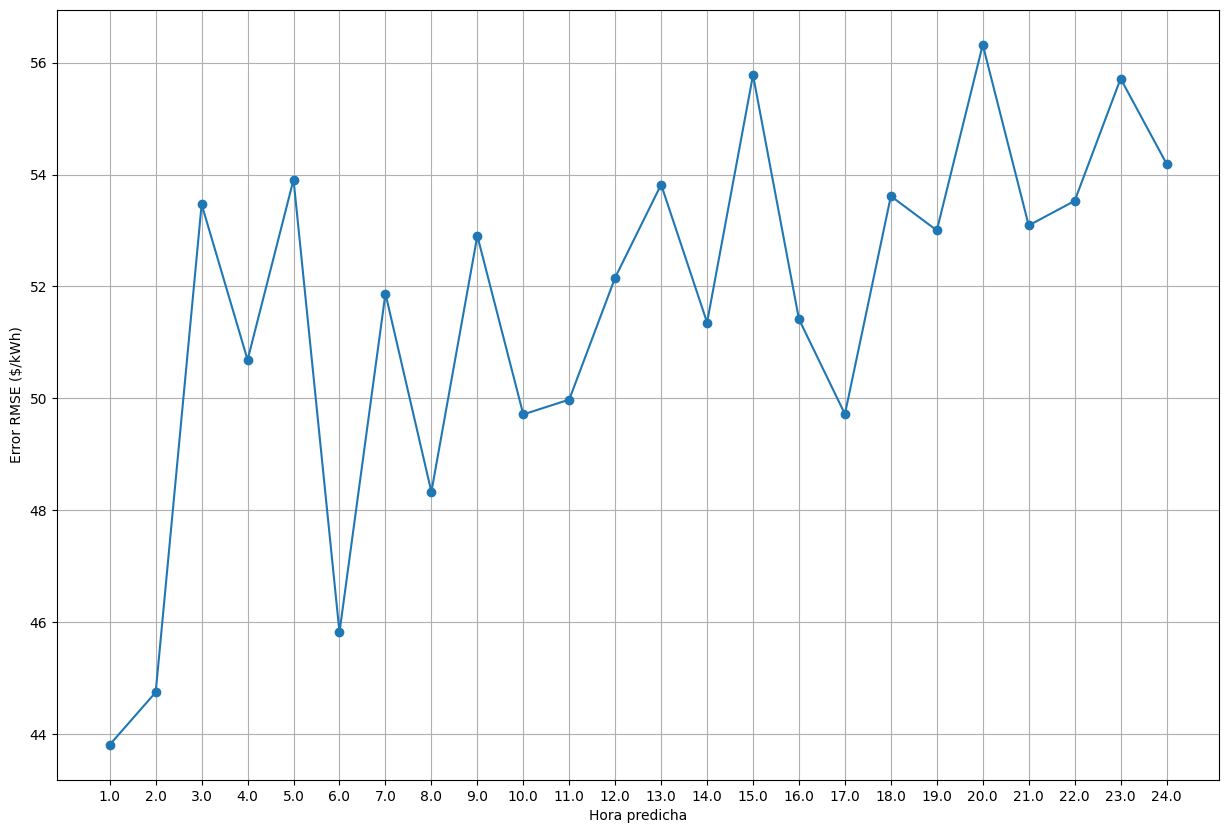

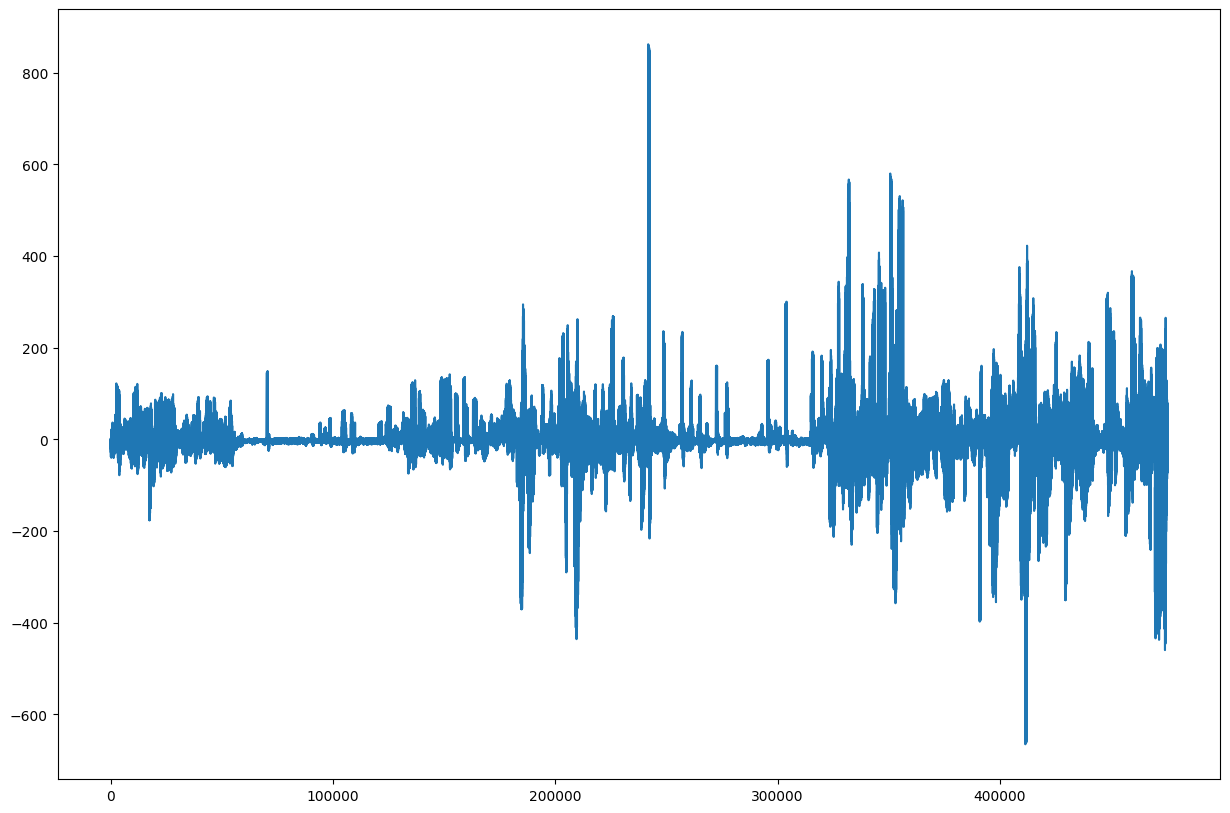

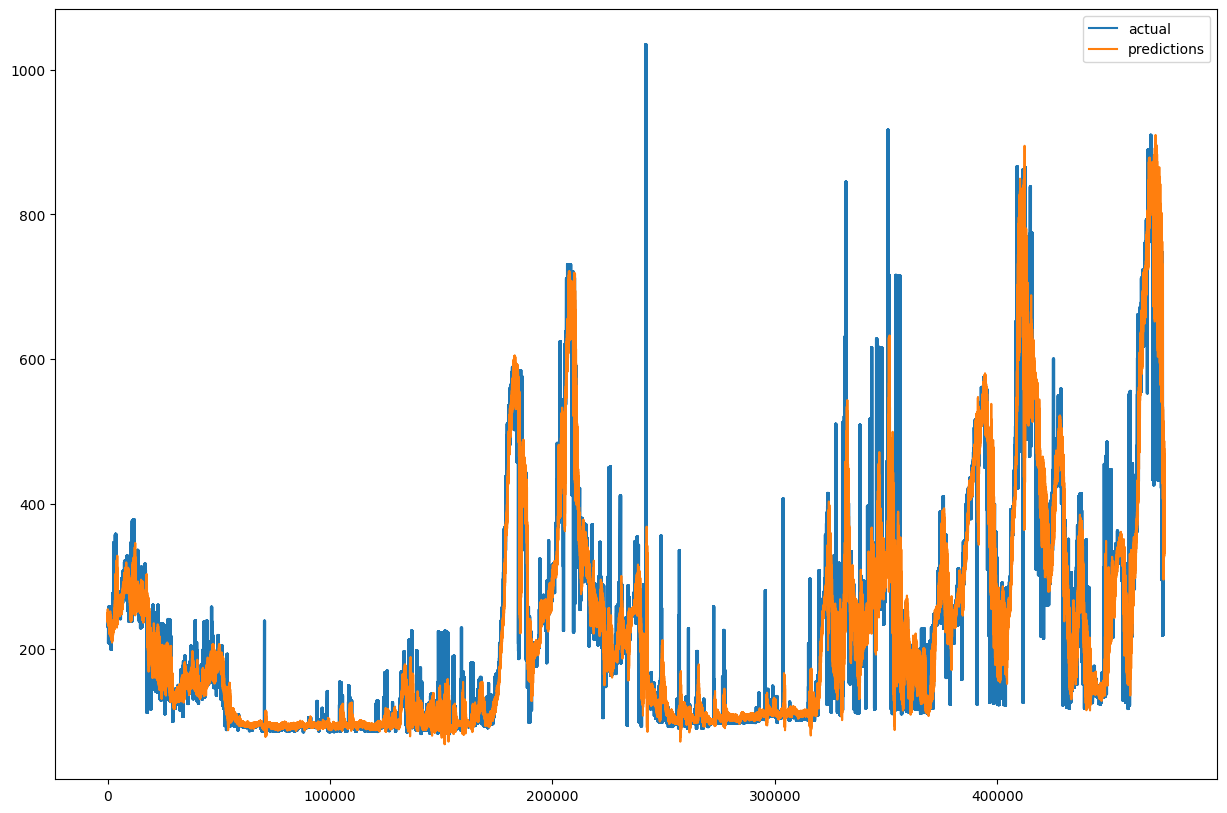

Epoch 1/50
698/698 [==============================] - 6s 6ms/step - loss: 0.9756 - val_loss: 0.8658
Epoch 2/50
698/698 [==============================] - 4s 6ms/step - loss: 0.8298 - val_loss: 0.7238
Epoch 3/50
698/698 [==============================] - 4s 6ms/step - loss: 0.6754 - val_loss: 0.5655
Epoch 4/50
698/698 [==============================] - 4s 6ms/step - loss: 0.5015 - val_loss: 0.3897
Epoch 5/50
698/698 [==============================] - 4s 6ms/step - loss: 0.3158 - val_loss: 0.2099
Epoch 6/50
698/698 [==============================] - 4s 6ms/step - loss: 0.1362 - val_loss: 0.0552
Epoch 7/50
698/698 [==============================] - 4s 5ms/step - loss: 0.0364 - val_loss: 0.0229
Epoch 8/50
698/698 [==============================] - 3s 5ms/step - loss: 0.0313 - val_loss: 0.0221
Epoch 9/50
698/698 [==============================] - 3s 4ms/step - loss: 0.0300 - val_loss: 0.0215
Epoch 10/50
698/698 [==============================] - 3s 4ms/step - loss: 0.0290 - val_loss: 0.0209

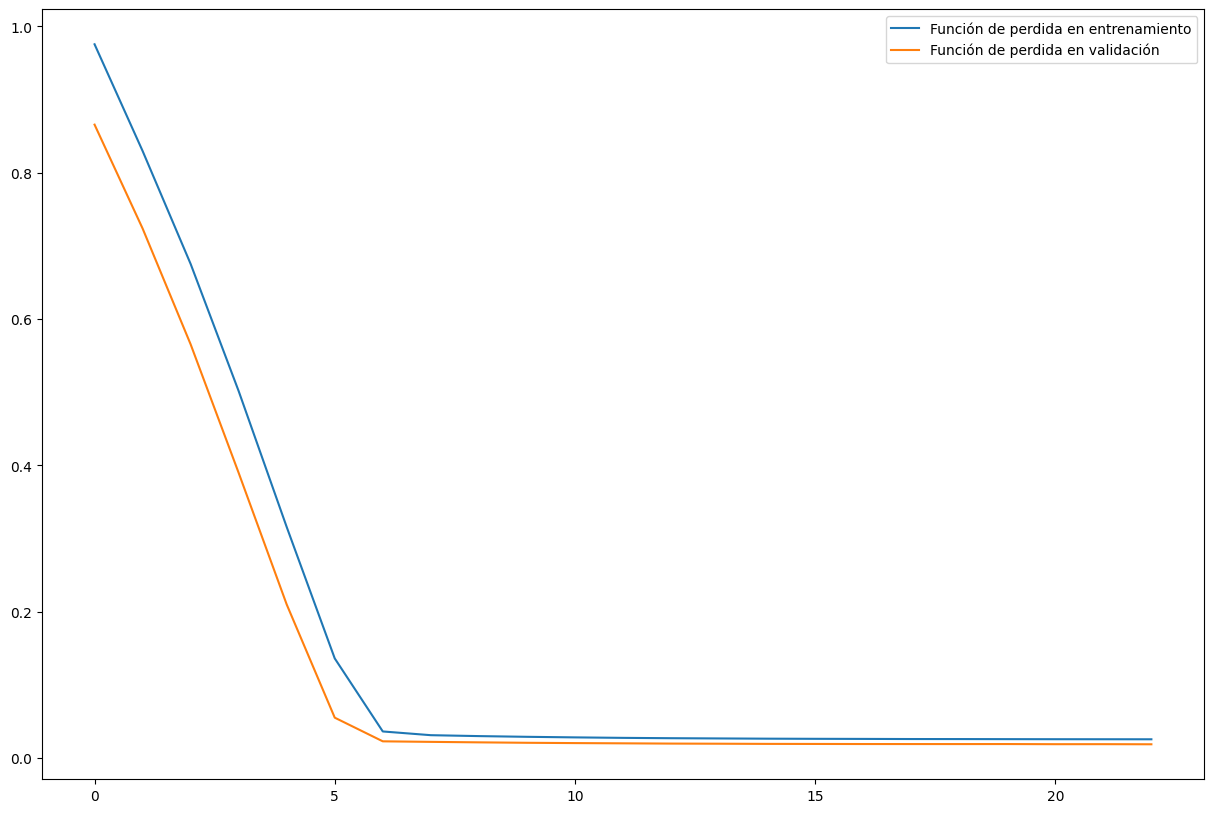

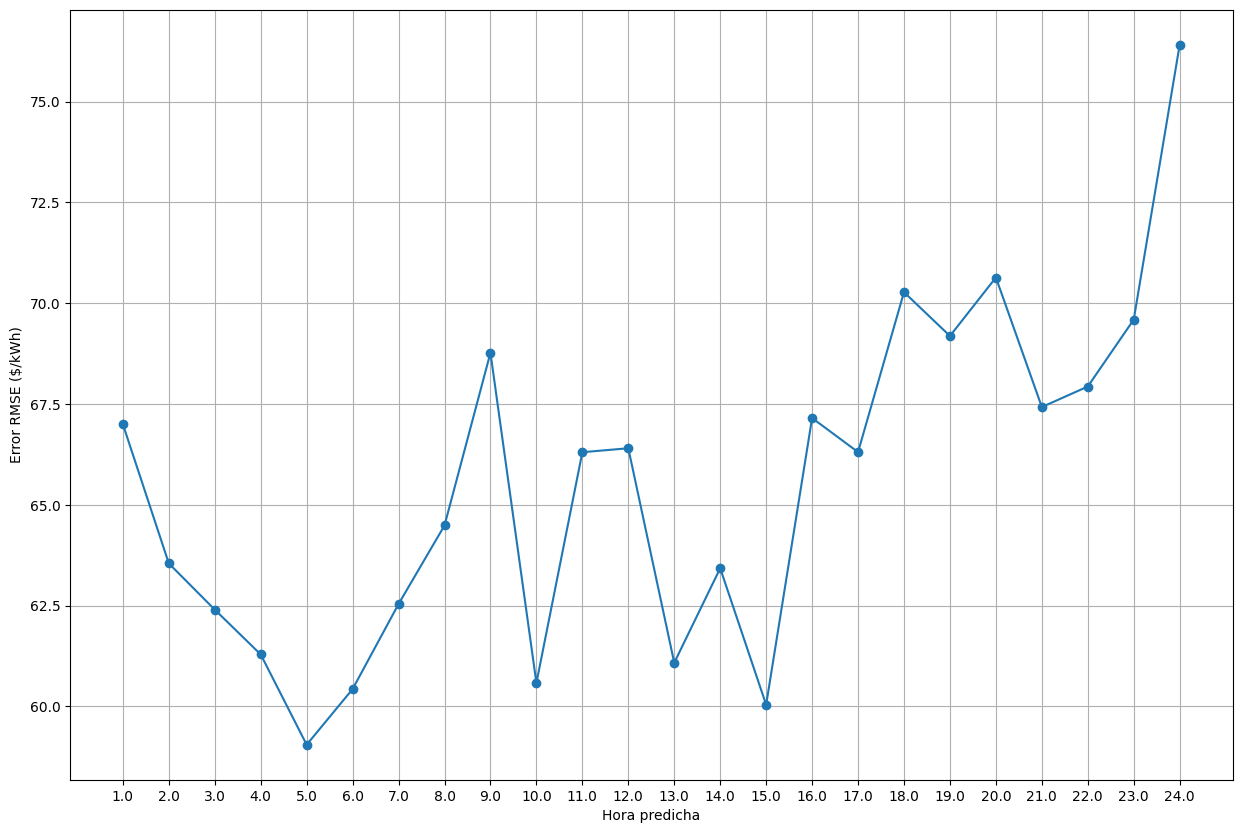

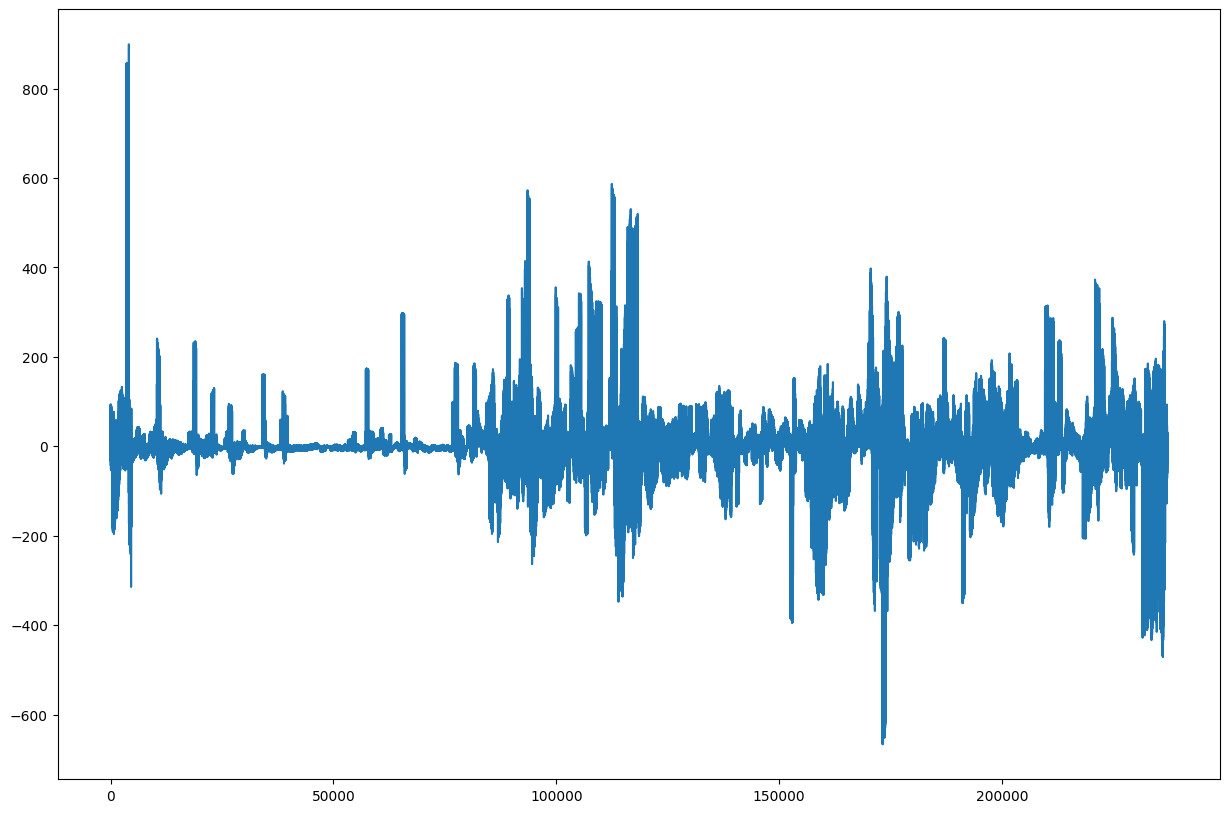

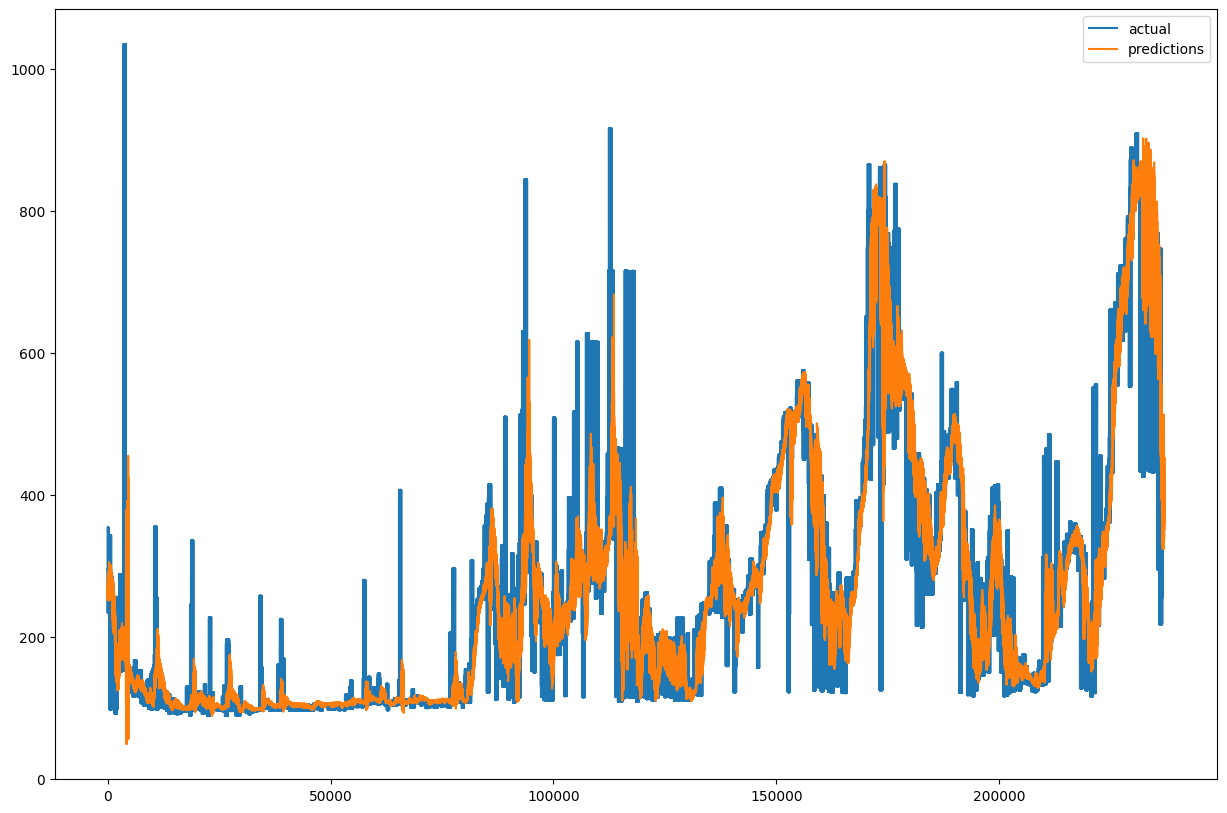

In [5]:
# Crear diferentes modelos base para cada tipo de particion
types = [(0.7,0.2,0.1),(0.8,0.1,0.1),(0.9,0.05,0.05)]
lista_results = []
INPUT_LENGTH = 24    # Registros de 24 horas consecutivas a la entrada
OUTPUT_LENGTH = 24   # El modelo va a predecir 24 horas a futuro
for i in types:
    df = pd.read_csv('df_data_colum.csv', parse_dates=['date_hour'], index_col='date_hour')
    tr, vl, ts = train_test_vali(df['price'], i[0], i[1], i[2])
    # plt.figure(figsize=(15,10))
    # plt.plot(tr, color='blue', label='Entrenamiento')
    # plt.plot(vl, color='red', label='Validación')
    # plt.plot(ts, color='green', label='Prueba')
    # plt.ylabel('Precio')
    # plt.title(f'Con {int(i[0]*100)}% en los datos de entrenamiento')
    # plt.legend()
    # plt.show()
    # Convertir a un problema supervisado
    x_tr, y_tr = crear_dataset_supervisado(tr.values, INPUT_LENGTH, OUTPUT_LENGTH)
    x_vl, y_vl = crear_dataset_supervisado(vl.values, INPUT_LENGTH, OUTPUT_LENGTH)
    x_ts, y_ts = crear_dataset_supervisado(ts.values, INPUT_LENGTH, OUTPUT_LENGTH)
    data_in = {
    'x_tr': x_tr, 'y_tr': y_tr,
    'x_vl': x_vl, 'y_vl': y_vl,
    'x_ts': x_ts, 'y_ts': y_ts,
    }
    # Escalar los datos
    data_s, scaler = escalar_dataset(data_in)
    x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
    x_vl_s, y_vl_s = data_s['x_vl_s'], data_s['y_vl_s']
    x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

    # Creacion del modelo
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, min_delta=0.003)
    optimizador = RMSprop(learning_rate=1e-5)
    modelo = Sequential()
    modelo.add(Conv1D(filters=10, kernel_size=2, activation='relu', input_shape=(INPUT_LENGTH, 1)))
    modelo.add(MaxPooling1D(pool_size=2))
    modelo.add(Flatten())
    modelo.add(Dense(50, activation='linear'))
    modelo.add(Dense(OUTPUT_LENGTH))
    modelo.compile(optimizer=optimizador, loss=root_mean_squared_error)
    # Entrenamiento del modelo
    start_time = time.time()
    historia = modelo.fit(
    x = x_tr_s,
    y = y_tr_s,
    batch_size = 256,
    epochs = 50,
    validation_data = (x_vl_s, y_vl_s),
    verbose=1, 
    callbacks=[early_stopping]
    )
    training_time = elapsed_time(start_time)
    # Comparativa de modelos
    rmse_tr = modelo.evaluate(x=x_tr_s, y=y_tr_s, verbose=0)
    rmse_vl = modelo.evaluate(x=x_vl_s, y=y_vl_s, verbose=0)
    rmse_ts = modelo.evaluate(x=x_ts_s, y=y_ts_s, verbose=0)

    df_history = pd.DataFrame(historia.history)
    x = df_history.index
    plt.figure(figsize=(15, 10))
    plt.plot(x, df_history['loss'], label='Función de perdida en entrenamiento')
    plt.plot(x, df_history['val_loss'], label='Función de perdida en validación')
    plt.legend()
    plt.show()

    # Hacer predicciones
    start_time = time.time()
    y_ts_pred, y_real = predecir(x_ts_s, modelo, scaler, y_ts_s, OUTPUT_LENGTH)
    prediction_time = elapsed_time(start_time)

    # Grafico de error (rmse) promedio por hora
    y_ts_pred_s = modelo.predict(x_ts_s, verbose=0)
    y_ts_pred = scaler.inverse_transform(y_ts_pred_s)
    diff_cuad = np.square(y_ts.squeeze()-y_ts_pred) # 
    proms = np.mean(diff_cuad, axis=0) # 1x4
    rmse = np.sqrt(proms) # 1x4
    t = np.linspace(1,24,24)
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.plot(t,rmse, marker='o')
    ax.set_xlabel('Hora predicha')
    ax.set_ylabel('Error RMSE ($/kWh)')
    plt.xticks(ticks=t, labels=t)
    plt.grid()
    plt.show()

    # Grafico de errores
    N = len(y_ts_pred)    # Número de predicciones (tamaño del set de prueba)
    ndato = np.linspace(1,N,N)
    errores = y_ts.flatten()-y_ts_pred.flatten()
    plt.figure(figsize=(15, 10))
    plt.plot(errores)

    # Grafico de predicciones
    df_result = pd.DataFrame({'predictions': y_ts_pred.flatten(), 'actual': y_real.flatten()})
    x = df_result.index
    plt.figure(figsize=(15, 10))
    plt.plot(x, df_result['actual'], label='actual')
    plt.plot(x, df_result['predictions'], label='predictions')
    plt.legend()
    plt.show()

    # Guardar el modelo
    modelo.save('cnn_model/bases_model/model_{train_size}.h5'.format(train_size=i[0]))

    # Evaluar el modelo
    mean_MAE = MAE(p_pred= df_result['predictions'], p_real=df_result['actual'])
    mean_RMSE = RMSE(p_pred= df_result['predictions'], p_real=df_result['actual'])
    mean_MAPE = MAPE(p_pred= df_result['predictions'], p_real=df_result['actual']) * 100
    mean_rMAE = rMAE(p_pred= np.array(df_result['predictions']), p_real=np.array(df_result['actual']), m='D')
    r2 = metrics.r2_score(y_real.flatten(), y_ts_pred.flatten())

    results = {'trainig_size': i[0], 'model': 'cnn', 'type': 'base', 'training_time': training_time, 
               'prediction_time': prediction_time, 'rmse_trainig': rmse_tr, 'rmse_validation': rmse_vl, 'rmse_test': rmse_ts, 
               'mean_MAE': mean_MAE, 'r2': r2, 'mean_RMSE': mean_RMSE, 'mean_MAPE': mean_MAPE, 'mean_rMAE': mean_rMAE}
    
    lista_results.append(results)

df_results_bases = pd.DataFrame(lista_results)
df_results_bases.to_csv('cnn_model/bases_model/df_results_bases.csv')
        